In [1]:

import os
import matplotlib.pyplot as plt
%matplotlib inline
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
# from pyvirtualdisplay import Display

from gym import wrappers
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers,models
import os
from tensorflow.keras import backend as K
%matplotlib inline
tf.config.experimental_run_functions_eagerly(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
# strategy = tf.distribute.MirroredStrategy()

print("*****************")
print(gpus)
print("*****************")

import matplotlib.animation as animation

*****************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
*****************


In [2]:
MEMORYLEN=int(1e5)
MEMORYLEN=int(10000)
BATCHSIZE=64
EPOCHS=1
# UPDATE_EVERY = 4


class DQNAgent():
    def __init__(self,actions=4,obs=8):
        self.actions=actions
        self.observations=obs
        self.model=self.load_model()
        self.target_model=self.load_model()
        
        self.copy_weights()

        self.memory=deque(maxlen=MEMORYLEN)
        self.gamma=0.99
        self.patience=0
        
           
    def play(self,observation,epsilon):
        if (len(self.memory)<BATCHSIZE):
            
            action=np.random.randint(low=0,high=self.actions)
            return action
        else:
            if np.random.random()>epsilon:
#                 print("model")
                action=self.model_predictions(observation)
            else:
                action=np.random.randint(low=0,high=self.actions)
            return action
            
    def step(self,state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
        if ((len(self.memory)>=BATCHSIZE) & (np.random.random() < 0.25 )):
            self.train_model()
        pass
 
    
    def train_model(self):
        
        rnd_indices = np.random.choice(len(self.memory), size=BATCHSIZE)
        data=np.array(self.memory)[rnd_indices]
        np.random.shuffle(data)
        
        state, action, reward, next_state, done=np.stack(data[:,0]),np.stack(data[:,1]),np.stack(data[:,2]),np.stack(data[:,3]),np.stack(data[:,4])
        qnext_max=np.max(self.target_model.predict(next_state),axis=1)
        qnext_max=reward+ self.gamma*qnext_max*(1-done)
        qtable_to_update=self.target_model.predict(state)
        for indx,qs in enumerate(qtable_to_update):
            qtable_to_update[indx,action[indx]]=qnext_max[indx]
        self.model.fit(state,qtable_to_update,epochs=1,verbose=0)
        self.patience+=1
        if self.patience==10:
            self.copy_weights()
            self.patience=0
        
        pass
    def model_predictions(self,observation):
        pred=self.model.predict(observation.reshape(1,-1))
        pred=np.argmax(pred)
        return pred
        
    def load_model(self):
        num_input = layers.Input(shape=(self.observations, ))
        x = layers.Dense(24,activation="relu")(num_input)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.1)(x)
        x = layers.Dense(24, activation="relu")(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.BatchNormalization()(x)
        y = layers.Dense(self.actions, activation="linear")(x)
        model = models.Model(inputs=num_input, outputs=y)
        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(lr=0.01,decay=0.01))
        model.summary()
        return model
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights()) 

In [3]:
import matplotlib.animation as animation
def gen_gif(agent,fname):


    max_t=1000

    env = gym.make('LunarLander-v2')
    eps_history=[]
    eps=0
    
    frames=[]
    state = env.reset()
    score = 0
    fig=plt.figure()
    for i_ in range(1,max_t+1):
        frames.append([plt.imshow(env.render(mode = 'rgb_array'),animated=True)])
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)

    #     agent.step(state, action, reward, next_state, done)

        state = next_state
        score += reward
#         print(reward,reward)
        if done:
            break 

    endtime= time.time() 

    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                                repeat_delay=0)

    ani.save('/anotherdrive/projects/gym/lunar/dqnote/gifs/lunar_{}_.gif'.format(fname),writer="PillowWriter")
    plt.close()
    print(score)
    pass

# gen_gif(agent,"test")

In [4]:
import time
from tqdm import tqdm
starttime=time.time()
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
agent=DQNAgent()

max_t=1000
eps_start=1.0
eps_end=0.2
eps_decay=0.995

eps = eps_start
env=gym.make('LunarLander-v2')
eps_history=[]
best_score=-9999
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)
        if reward==-100:
            reward=-25
        if reward==100:
            reward=25
        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
#     if np.mean(scores_window)>=best_score:
#         best_score=np.mean(scores_window)
#         print("new best_score: {}".format(best_score))
#         gen_gif(agent,i_episode)
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
    if np.mean(scores_window)>=100.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 24)                216       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 100       
Total params: 916
Trainable params: 916
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
______________________________________________

KeyboardInterrupt: 

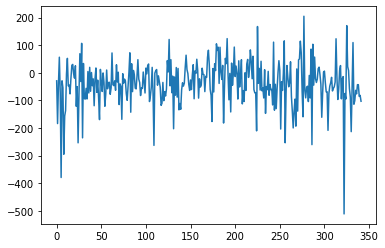

In [7]:
import pandas as pd
pd.Series(scores).plot()

In [46]:
plt.close('all')

In [ ]:
import time
from tqdm import tqdm
starttime=time.time()
# scores = []                        # list containing scores from each episode
# scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
# agent=DQNAgent()

max_t=1000
eps_start=0.4
eps_end=0.2
eps_decay=0.998

eps = eps_start
# env=gym.make('LunarLander-v2')
# eps_history=[]
# best_score=-9999
for i_episode in range(400, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)
        if reward==-100:
            reward=-35
        if reward==100:
            reward=35
        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
    if np.mean(scores_window)>=best_score:
        best_score=np.mean(scores_window)
        print("new best_score: {}".format(best_score))
#         gen_gif(agent,i_episode)
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
    if np.mean(scores_window)>=190.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

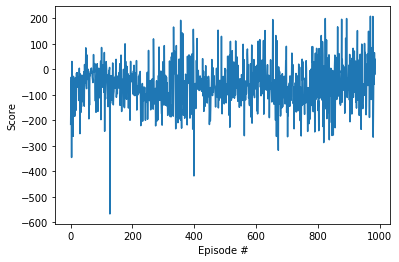

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [52]:
import matplotlib.animation as animation
# def gen_gif(agent,fname):


max_t=1000

env = gym.make('LunarLander-v2')
eps_history=[]
eps=0

frames=[]
state = env.reset()
score = 0
fig=plt.figure()
for i_ in range(1,max_t+1):
    frames.append([plt.imshow(env.render(mode = 'rgb_array'),animated=True)])
    action = agent.play(state,eps)
    next_state, reward, done, _ = env.step(action)

#     agent.step(state, action, reward, next_state, done)

    state = next_state
    score += reward
#         print(reward,reward)
    if done:
        break 

endtime= time.time() 

ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                            repeat_delay=0)

ani.save('/anotherdrive/projects/gym/lunar/dqnote/gifs/lunar_MID2_.gif',writer="PillowWriter")
plt.close()
print(score)
    

# gen_gif(agent,"test")

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


-194.22328616287524


In [ ]:
asdsa

In [10]:
import time
from tqdm import tqdm
starttime=time.time()
# scores = []                        # list containing scores from each episode
# scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
# agent=DQNAgent()

max_t=1000
eps_start=0.4
eps_end=0.02
eps_decay=0.996

eps = eps_start
# env=gym.make('LunarLander-v2')
# eps_history=[]
# best_score=-9999
for i_episode in range(1400, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)
        if reward==-100:
            reward=-35
        if reward==100:
            reward=35
        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
#     if np.mean(scores_window)>=best_score:
#         best_score=np.mean(scores_window)
#         print("new best_score: {}".format(best_score))
#         gen_gif(agent,i_episode)
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
    if np.mean(scores_window)>=190.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 1400	Average Score: -61.98 Epsilon: 0.39840000000000003
Episode 1410	Average Score: -56.24 Epsilon: 0.38274780960351956
Episode 1420	Average Score: -58.26 Epsilon: 0.3677105566171989
Episode 1430	Average Score: -55.15 Epsilon: 0.35326408160974865
Episode 1440	Average Score: -57.97 Epsilon: 0.3393851743165921
Episode 1450	Average Score: -57.53 Epsilon: 0.3260515363493582
Episode 1460	Average Score: -58.26 Epsilon: 0.3132417453704297
Episode 1470	Average Score: -53.77 Epsilon: 0.3009352206749884
Episode 1480	Average Score: -50.77 Epsilon: 0.28911219012525996
Episode 1490	Average Score: -37.11 Epsilon: 0.2777536583838342
Episode 1500	Average Score: -30.97 Epsilon: 0.2668413763950221
Episode 1510	Average Score: -38.51 Epsilon: 0.2563578120652184
Episode 1520	Average Score: -42.85 Epsilon: 0.24628612209516335
Episode 1530	Average Score: -46.76 Epsilon: 0.23661012491884725
Episode 1540	Average Score: -43.05 Epsilon: 0.22731427470558221
Episode 1550	Average Score: -38.38 Epsilon: 0.21

KeyboardInterrupt: 

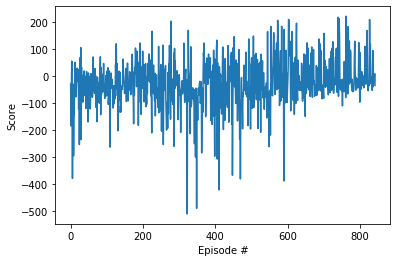

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
gen_gif(agent,"MID#4")

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


145.41298593134044


Episode 2000	Average Score: -1.26 Epsilon: 0.19920000000000002
Episode 2010	Average Score: 8.42 Epsilon: 0.19137390480175978
Episode 2020	Average Score: 10.05 Epsilon: 0.18385527830859946
Episode 2030	Average Score: 9.56 Epsilon: 0.17663204080487432
Episode 2040	Average Score: 18.87 Epsilon: 0.16969258715829605
Episode 2050	Average Score: 23.15 Epsilon: 0.1630257681746791
Episode 2060	Average Score: 27.34 Epsilon: 0.15662087268521485
Episode 2070	Average Score: 34.82 Epsilon: 0.1504676103374942
Episode 2080	Average Score: 37.89 Epsilon: 0.14455609506262998
Episode 2090	Average Score: 41.82 Epsilon: 0.1388768291919171
Episode 2100	Average Score: 47.71 Epsilon: 0.13342068819751104
Episode 2110	Average Score: 46.64 Epsilon: 0.1281789060326092
Episode 2120	Average Score: 53.78 Epsilon: 0.12314306104758167
Episode 2130	Average Score: 58.22 Epsilon: 0.11830506245942363
Episode 2140	Average Score: 56.23 Epsilon: 0.11365713735279111
Episode 2150	Average Score: 54.02 Epsilon: 0.1091918181917348

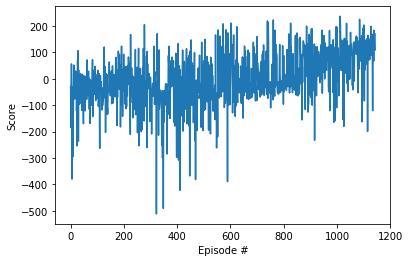

In [14]:
import time
from tqdm import tqdm
starttime=time.time()
# scores = []                        # list containing scores from each episode
# scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
# agent=DQNAgent()

max_t=1000
eps_start=0.2
eps_end=0.02
eps_decay=0.996

eps = eps_start
# env=gym.make('LunarLander-v2')
# eps_history=[]
# best_score=-9999
for i_episode in range(2000, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)
        if reward==-100:
            reward=-35
        if reward==100:
            reward=35
        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
#     if np.mean(scores_window)>=best_score:
#         best_score=np.mean(scores_window)
#         print("new best_score: {}".format(best_score))
#         gen_gif(agent,i_episode)
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
    if np.mean(scores_window)>=100.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
gen_gif(agent,"final_dqn")

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


203.58188811099114


In [16]:
gen_gif(agent,"final_dqn2")
gen_gif(agent,"final_dqn3")
gen_gif(agent,"final_dqn4")

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


37.774721101784735


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


185.28951679335177


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


202.04373747145843


In [17]:
gen_gif(agent,"final_dqn5")
gen_gif(agent,"final_dqn6")

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


231.93757249851234


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


-74.3382663489239
